# Numerical solution of the 1d burgers equation using PINN 
## Governing equations
$u_t+uu_x-\frac{0,01}{\pi}u_{xx} = 0, \quad x \in [-1,1], \quad t \in [0,1]$

$u(x,0) = -\sin(\pi x)$

$u(-1,t) = u(1,t) = 0$

## Bibliography
### Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations. Authors: Maziar Raissi, Paris Perdikaris and George Em Karniadakis


# Libraries

In [11]:
import jax, optax, flax
import pickle
import functools
import matplotlib.pyplot, matplotlib.animation
import numpy

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
#jax.config.update('jax_disable_jit', True) # Desactive the compilation for better debugging
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Neural network

In [12]:
class MLP(flax.linen.Module):
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure, activation function and a bool to indicates if it's occurring a training
     """
    layers: list
    training: bool

    @flax.linen.compact
    def __call__(self, x):
        """
        Compute the output of the neural network
        Parameters
        ----------
        x : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        x : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- numerical output of the neural network	(u,v,p)
        """
        
        x = flax.linen.BatchNorm(use_running_average=not self.training)(x)
        for i in range(1,len(self.layers)-1):
            x = flax.linen.Dense(self.layers[i])(x)
            x = flax.linen.BatchNorm(use_running_average=not self.training)(x)
            x = flax.linen.tanh(x)
            #x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
        x = flax.linen.Dense(self.layers[-1])(x)
        
        return x


# Operators

In [13]:
class PDE_operators1d:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    
    # Class initialization
    def __init__(self, function):
        self.function = function

    @functools.partial(jax.jit, static_argnums=(0,))    
    def laplacian(self, params, inputs):
        """
        Compute the laplacian of u
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        laplacian : jax.numpy.array[batch_size]
            -- numerical values of the laplacian applied to the inputs
        """

        fun = lambda params, x, t: self.function(params, x, t)[:,0]

        @functools.partial(jax.jit)    
        def action(params,x,t):         # function to vectorize the laplacian
            u_xx = jax.jacfwd(jax.jacfwd(fun, 1), 1)(params, x, t)
            return u_xx

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        lapu = vec_fun(params, inputs[:,0], inputs[:,1])

        return lapu


    # Compute material derivative
    @functools.partial(jax.jit, static_argnums=(0,))    
    def material_derivative(self, params, inputs):
        """
        Compute the material derivative of u
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        mat_derivative : jax.numpy.array[batch_size]
            -- numerical values of the material derivative of u applied to the inputs
        """

        result = self.function(params, inputs[:,0], inputs[:,1])

        @functools.partial(jax.jit)    
        def all_derivatives(params, inputs):
            fun = lambda params, x, t: self.function(params, x, t)[:,0]

            @functools.partial(jax.jit)    
            def action(params, x, t):                     # function to vectorize the laplacian
                u_x = jax.jacfwd(fun, 1)(params, x, t)
                u_t = jax.jacfwd(fun, 2)(params, x, t)
                return jax.numpy.column_stack((u_x, u_t))

            vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
            derivatives = vec_fun(params, inputs[:,0], inputs[:,1])
            derivatives = derivatives.reshape(derivatives.shape[0], derivatives.shape[2])
            return derivatives

        vector = jax.numpy.column_stack((result[:,0], jax.numpy.ones_like(result[:,0])))
        all_first_derivatives_u = all_derivatives(params, inputs)
        mat_derivative_u = jax.numpy.einsum('ij,ij->i', all_first_derivatives_u, vector).reshape(-1,1)

        return mat_derivative_u

# Physics Informed Neural Network

In [14]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """

    # Class initialization
    def __init__(self, NN_evaluation, optimizer):

        self.NN_evaluation = NN_evaluation
        self.optimizer = optimizer

        self.operators = PDE_operators1d(self.solution)
        self.material_derivative = self.operators.material_derivative
        self.laplacian = self.operators.laplacian

    # Compute the solution of the PDE on the points (x,t)
    @functools.partial(jax.jit, static_argnums=(0,))    
    def solution(self, params, inputX, inputT):
        """
        Compute the solution of the PDE on the points (x,t)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the mesh
        inputT : jax.numpy.array[batch_size]
            -- points on the time-axis
        Returns
        -------
        applied_solution : jax.numpy.ndarray[batch_size,batch_size,batch_size]
            -- PINN solution applied to inputs. return u
        """
        inputs = jax.numpy.column_stack((inputX, inputT))
        NN_output = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        return NN_output

    # Loss function respective to burger equation
    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_momentum_equations(self, params, inputs):
        """
        Compute the residual of the pde
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from the mesh
        Returns
        -------
        loss_residual : a float.64
            -- loss function applied to inputs
        """

        preds_momentum = self.material_derivative(params, inputs) - self.laplacian(params, inputs)*0.01/jax.numpy.pi
        loss_momentum = jax.numpy.mean(preds_momentum**2)
        
        return loss_momentum

    # Loss function respective to boundary
    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_boundary(self, params, inputs):
        """
        Compute the loss function at the boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_bound : a float.64
            -- loss function applied to inputs
        """

        preds_bound = self.solution(params, inputs[:,0], inputs[:,1])[:,0]
        loss_bound = jax.numpy.mean(preds_bound**2)
        
        return loss_bound

    # Loss function respective to initial time
    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_initial_time(self, params, inputs):  
        """
        Compute the loss function at the initial conditions
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from initial condition
        Returns
        -------
        loss_initial : a float.64
            -- loss function applied to inputs
        """

        exact = -jax.numpy.sin(jax.numpy.pi*inputs[:,0])
        preds_initial_time = self.solution(params, inputs[:,0], inputs[:,1])[:,0]
        loss_initial_time = jax.numpy.mean((preds_initial_time - exact)**2)

        return loss_initial_time

    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_function(self, params, inside, bound, initial):
        """
        Compute the sum of each loss function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        losses : dictionary with the keys (loss_m, loss_b, loss_i)
            -- current values of each loss function
        """

        loss_bound = self.loss_boundary(params, bound)
        loss_initial = self.loss_initial_time(params, initial)
        loss_momen = self.loss_momentum_equations(params, inside)
        loss_sum = loss_bound+loss_initial+loss_momen
        losses = jax.numpy.array([loss_momen, loss_bound, loss_initial])

        return loss_sum, losses

    @functools.partial(jax.jit, static_argnums=(0,))    
    def train_step(self, params, opt_state, inside, bound, initial):
        """
        Make just one step of the training
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax
            -- state(hystorical) of the gradient descent
        inside : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        losses : dictionary with the keys (loss_m, loss_b, loss_i)
            -- current values of each loss function
        """

        (loss,losses), gradient = jax.value_and_grad(self.loss_function, has_aux=True)(params, inside, bound, initial)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state, losses


# Parameters

In [15]:
# Neural network parameters
SEED = 351
n_features, n_targets = 2, 1            # Input and output dimension 
layers = [n_features, 50, 50, 50, 50, 50, n_targets]             # Layers structure
lr_scheduler = optax.linear_schedule(0.0005, 0.00001, transition_steps = 50, transition_begin = 5000)
#lr_scheduler = 0.00001               # learning rate
optimizer = optax.adam(lr_scheduler)

# Training parameters
maximum_num_epochs = 50000       
report_steps = 100
options = 1 # If 1 we start a new training

# Data parameters
N_inside = 64                # number of points inside the mesh
N_bound = 16                   # number of points at the boundary
domain_bounds = jax.numpy.column_stack(([-1,0], [1,1]))      # minimal and maximal value of each axis (x,t)

# 1D dataset creation

In [16]:
#### Boundary data
X_bound = jax.numpy.array(numpy.concatenate((domain_bounds[0,0]*numpy.ones(N_bound//2), domain_bounds[0,1]*numpy.ones(N_bound//2))))

#### Inside data
ran_key, batch_key = jax.random.split(jax.random.PRNGKey(1))
X_inside = jax.random.uniform(batch_key, shape=(N_inside, ), minval = domain_bounds[0,0], maxval = domain_bounds[0,1])

# Model initialization

In [17]:
training_model = MLP(layers,training=True)     
key1, key2, key3 = jax.random.split(jax.random.PRNGKey(SEED), 3)
x = jax.random.uniform(key1, (10, layers[0]))
params = training_model.init({'params': key2}, x)

eval_model = MLP(layers,training=False)
NN_eval = eval_model.apply   # Evaluate function

solver = PINN(NN_eval, optimizer)
opt_state = optimizer.init(params)

# Training

In [18]:
print("Training start")
if options == 1:            # begin a new training
    loss_history = []
    loss_m = []               # residual loss
    loss_b = []               # boundary loss
    loss_i = []               # boundary initial condition

    # Main loop to solve the PDE
    for ibatch in range(maximum_num_epochs+1):
        XT_bound = jax.numpy.column_stack((X_bound,numpy.random.uniform(domain_bounds[1,0],domain_bounds[1,1],size=(N_bound,))))
        XT_inside = jax.numpy.column_stack((X_inside,numpy.random.uniform(domain_bounds[1,0],domain_bounds[1,1],size=(N_inside,))))
        XT_initial = jax.numpy.column_stack((X_inside,jax.numpy.zeros(N_inside)))

        loss, params, opt_state, losses = solver.train_step(params,opt_state, XT_inside, XT_bound, XT_initial)

        loss_m.append(float(losses[0]))
        loss_b.append(float(losses[1]))
        loss_i.append(float(losses[2]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%report_steps == report_steps-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
                pickle.dump(params, open("./NN_saves/params_checkpoint_burgers", "wb"))
                pickle.dump(opt_state, open("./NN_saves/opt_state_checkpoint_burgers", "wb"))
                pickle.dump(loss_history, open("./NN_saves/loss_history_burgers", "wb"))
                pickle.dump(loss_m, open("./NN_saves/loss_m_burgers", "wb"))
                pickle.dump(loss_b, open("./NN_saves/loss_b_burgers", "wb"))
                pickle.dump(loss_i, open("./NN_saves/loss_i_burgers", "wb"))

elif options == 2:   # continue the last training
    params = pickle.load(open("./NN_saves/params_checkpoint_burgers", "rb"))
    opt_state = pickle.load(open("./NN_saves/opt_state_checkpoint_burgers", "rb"))
    loss_history = pickle.load(open("./NN_saves/loss_history_burgers", "rb"))
    loss_m = pickle.load(open("./NN_saves/loss_m_burgers", "rb"))
    loss_b = pickle.load(open("./NN_saves/loss_b_burgers", "rb"))
    loss_i = pickle.load(open("./NN_saves/loss_i_burgers", "rb"))
    iepoch = len(loss_history)

    # Main loop to solve the PDE
    for ibatch in range(iepoch, maximum_num_epochs+1):
        XT_bound = jax.numpy.column_stack((X_bound,numpy.random.uniform(domain_bounds[1,0],domain_bounds[1,1],size=(N_bound,))))
        XT_inside = jax.numpy.column_stack((X_inside,numpy.random.uniform(domain_bounds[1,0],domain_bounds[1,1],size=(N_inside,))))
        XT_initial = jax.numpy.column_stack((X_inside,jax.numpy.zeros(N_inside)))

        loss, params, opt_state, losses = solver.train_step(params,opt_state, XT_inside, XT_bound, XT_initial)

        loss_m.append(float(losses[0]))
        loss_b.append(float(losses[1]))
        loss_i.append(float(losses[2]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%report_steps==report_steps-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
                pickle.dump(params, open("./NN_saves/params_checkpoint_burgers", "wb"))
                pickle.dump(opt_state, open("./NN_saves/opt_state_checkpoint_burgers", "wb"))
                pickle.dump(loss_history, open("./NN_saves/loss_history_burgers", "wb"))
                pickle.dump(loss_m, open("./NN_saves/loss_m_burgers", "wb"))
                pickle.dump(loss_b, open("./NN_saves/loss_b_burgers", "wb"))
                pickle.dump(loss_i, open("./NN_saves/loss_i_burgers", "wb"))



Training start
Epoch n°100:  0.17863600517250505
Epoch n°200:  0.1428776889187
Epoch n°300:  0.11594751091760246
Epoch n°400:  0.10840823390780523
Epoch n°500:  0.12036564978413494
Epoch n°600:  0.06861159319780775
Epoch n°700:  0.06078636485929061
Epoch n°800:  0.02586619181467638
Epoch n°900:  0.020533443024104515
Epoch n°1000:  0.020619323976876137
Epoch n°1100:  0.013960633609734544
Epoch n°1200:  0.009198730389203429
Epoch n°1300:  0.009503565867815558
Epoch n°1400:  0.009761852340467168
Epoch n°1500:  0.004836721523892372
Epoch n°1600:  0.005006556275944776
Epoch n°1700:  0.006678431893405291
Epoch n°1800:  0.0021989205037264265
Epoch n°1900:  0.005229319452300744
Epoch n°2000:  0.005331492675409019
Epoch n°2100:  0.001740294357519906
Epoch n°2200:  0.002105727799378584
Epoch n°2300:  0.0020347116915816065
Epoch n°2400:  0.0020543173774788238
Epoch n°2500:  0.000891478905299548
Epoch n°2600:  0.0012337838587331135
Epoch n°2700:  0.0023852389911160885
Epoch n°2800:  0.000856821410

# Loss function

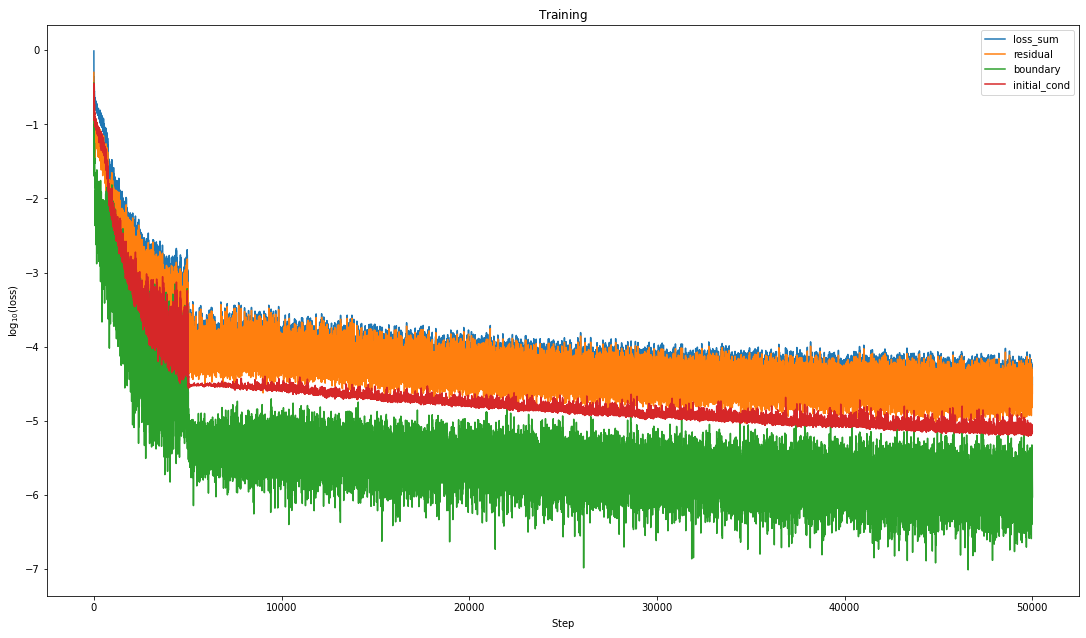

In [19]:
fig, ax = matplotlib.pyplot.subplots(1, 1)
fig.set_size_inches(18.5, 10.5)
__ = ax.plot(numpy.log10(loss_history))
__ = ax.plot(numpy.log10(numpy.array(loss_m)))
__ = ax.plot(numpy.log10(numpy.array(loss_b)))
__ = ax.plot(numpy.log10(numpy.array(loss_i)))
xlabel = ax.set_xlabel(r'${\rm Step}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss)}$')
title = ax.set_title(r'${\rm Training}$')
ax.legend(['loss_sum','residual','boundary','initial_cond'])
matplotlib.pyplot.savefig('./images/loss_function.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()

# Solution

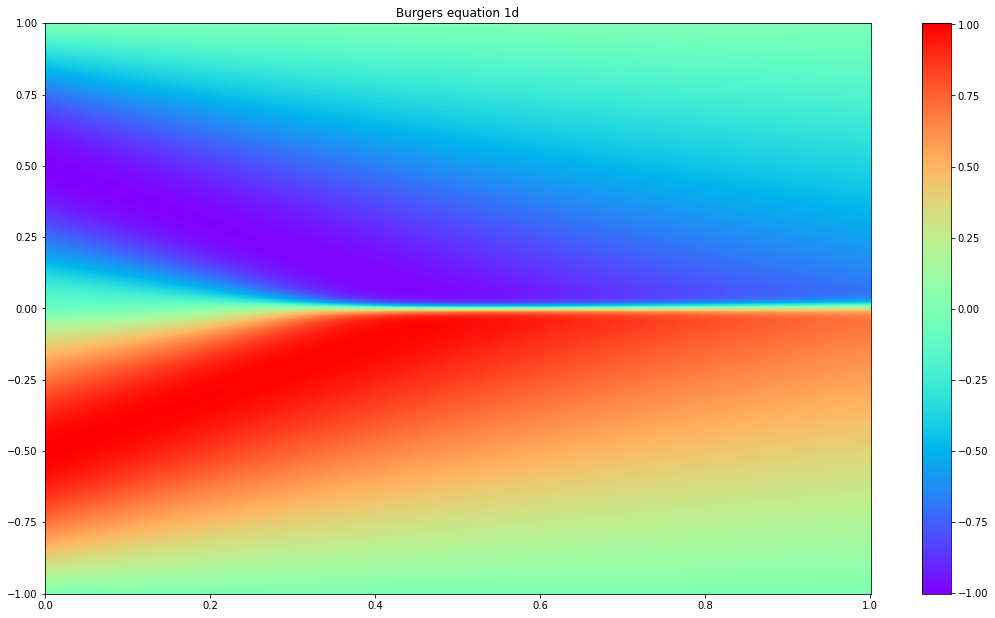

In [20]:
npoints = 1000
values = numpy.zeros((npoints,npoints))

x, t = numpy.meshgrid(numpy.linspace(domain_bounds[0,0], domain_bounds[0,1], npoints), numpy.linspace(domain_bounds[1,0], domain_bounds[1,1], npoints))
fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18.5, 10.5)
title = ax.set_title('Burgers equation 1d')

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    values[i,:] = solver.solution(params, x[i,:], t[i,:])[:,0]

graph = matplotlib.pyplot.pcolormesh(t, x, values, cmap = 'rainbow')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.savefig('./images/burgers.png', bbox_inches = 'tight')
matplotlib.pyplot.show()  